In [1]:
import flare_classifier as fc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import light_curve as lc

In [2]:
import ast

def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [3]:
POSITIVE_CLASS_PATH = 'generated_500k.csv'
NEGATIVE_CLASS_PATH = 'lc_1M.csv'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [4]:
positive_class = pd.read_csv(POSITIVE_CLASS_PATH, converters={'mjd': from_np_array, 'mag': from_np_array, 'magerr': from_np_array})
positive_class = positive_class[positive_class['chi2'] > 3].reset_index(drop=True)

negative_class = pd.read_csv(NEGATIVE_CLASS_PATH, converters={'mjd': from_np_array, 'mag': from_np_array, 'magerr': from_np_array})

In [5]:
positive_class['is_flare'] = np.ones(len(positive_class))
negative_class['is_flare'] = np.zeros(len(negative_class))

pos_class_featured = fc.feature_extractor(positive_class)
neg_class_featured = fc.feature_extractor(negative_class)

In [6]:
train_size = 0.9
test_size = 0.1

pos_train, pos_test, pos_val = fc.data_splitter(pos_class_featured, train_size, test_size)

shuffled_neg = neg_class_featured.sample(frac=1, random_state=rng)
split_idx = int(len(negative_class) * train_size)
neg_train, neg_test = shuffled_neg[:split_idx].reset_index(drop=True), shuffled_neg[split_idx:-1].reset_index(drop=True)

In [7]:
assert len(pos_class_featured) == len(pos_train) + len(pos_test) + len(pos_val)

In [8]:
train_data = pd.concat([pos_train, neg_train], axis=0)
test_data = pd.concat([pos_test, neg_test], axis=0)

assert len(train_data) == len(pos_train) + len(neg_train)
assert len(test_data) == len(pos_test) + len(neg_test)

In [9]:
train_data_clean = train_data.copy()
train_data_clean = train_data_clean.sample(frac=1, random_state=rng)
train_data_clean = train_data.drop(['TIC', 'flare_time', 'chi2', 'Unnamed: 0', 'oid_idx', 'filter', 'oid', 'mjd', 'mag', 'magerr', 'dec', 'ra', 'fieldid', 'reduced_chi_square'], axis=1)

test_data_clean = test_data.copy()
test_data_clean = test_data_clean.sample(frac=1, random_state=rng)
test_data_clean = test_data.drop(['TIC', 'flare_time', 'chi2', 'Unnamed: 0', 'oid_idx', 'filter', 'oid', 'mjd', 'mag', 'magerr', 'dec', 'ra', 'fieldid', 'reduced_chi_square'], axis=1)

In [10]:
X_train, y_train = train_data_clean.drop(['is_flare'], axis=1), train_data_clean['is_flare'].to_numpy()
X_test, y_test = test_data_clean.drop(['is_flare'], axis=1), test_data_clean['is_flare'].to_numpy()

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=100, n_jobs=-1, random_state=42)

In [12]:
test_predict = clf.predict(X_test)

In [13]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

print(f'recall: {recall_score(y_test, test_predict)}')
print(f'precision: {precision_score(y_test, test_predict)}')
print(f'accuracy: {accuracy_score(y_test, test_predict)}')
print(f'balanced accuracy: {balanced_accuracy_score(y_test, test_predict)}')
print(f'f1_score: {f1_score(y_test, test_predict)}')

recall: 0.8070861741365821
precision: 0.916138036031464
accuracy: 0.9595056534315014
balanced accuracy: 0.8969330209676301
f1_score: 0.8581615069225741


In [14]:
from sklearn.ensemble import RandomForestClassifier

clf_balanced = RandomForestClassifier(max_depth=100, 
                                      random_state=42,
                                      n_jobs=-1,
                                      class_weight='balanced')
clf_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=100, n_jobs=-1,
                       random_state=42)

In [15]:
test_predict = clf_balanced.predict(X_test)

print(f'recall: {recall_score(y_test, test_predict)}')
print(f'precision: {precision_score(y_test, test_predict)}')
print(f'accuracy: {accuracy_score(y_test, test_predict)}')
print(f'balanced accuracy: {balanced_accuracy_score(y_test, test_predict)}')
print(f'f1_score: {f1_score(y_test, test_predict)}')

recall: 0.7914943556499385
precision: 0.9200337793945693
accuracy: 0.9579109870815061
balanced accuracy: 0.8895921162743538
f1_score: 0.8509372746935832


In [16]:
test_predict = clf.predict(X_test)

false_predicted = np.where((test_predict != y_test) * (test_predict == 1.0))[0]

In [17]:
def plot_false_predicted(clf, pos=True):
    test_predict = clf.predict(X_test)
    
    if pos:
        false_predicted = np.where((test_predict != y_test) * (test_predict == 1))[0]
    else:
        false_predicted = np.where((test_predict != y_test) * (test_predict == 0))[0]

    idx = rng.choice(false_predicted, 6)
    
    plt.figure(figsize=(14, 10))
    
    for i, id in enumerate(idx):
        plt.subplot(3, 2, i+1)
        plt.scatter(test_data.iloc[id]['mjd'], test_data.iloc[id]['mag'])
        plt.ylabel('mag')
        plt.xlabel('mjd')
        
        if pos:
            plt.title(test_data.iloc[id]['oid'])
            print(test_data.iloc[id]['oid'])
        plt.gca().invert_yaxis()  
    
    plt.tight_layout()
    plt.show()

334211400150771
541210400037524
486210400101318
592206300079149
488206100039213
386207300074296


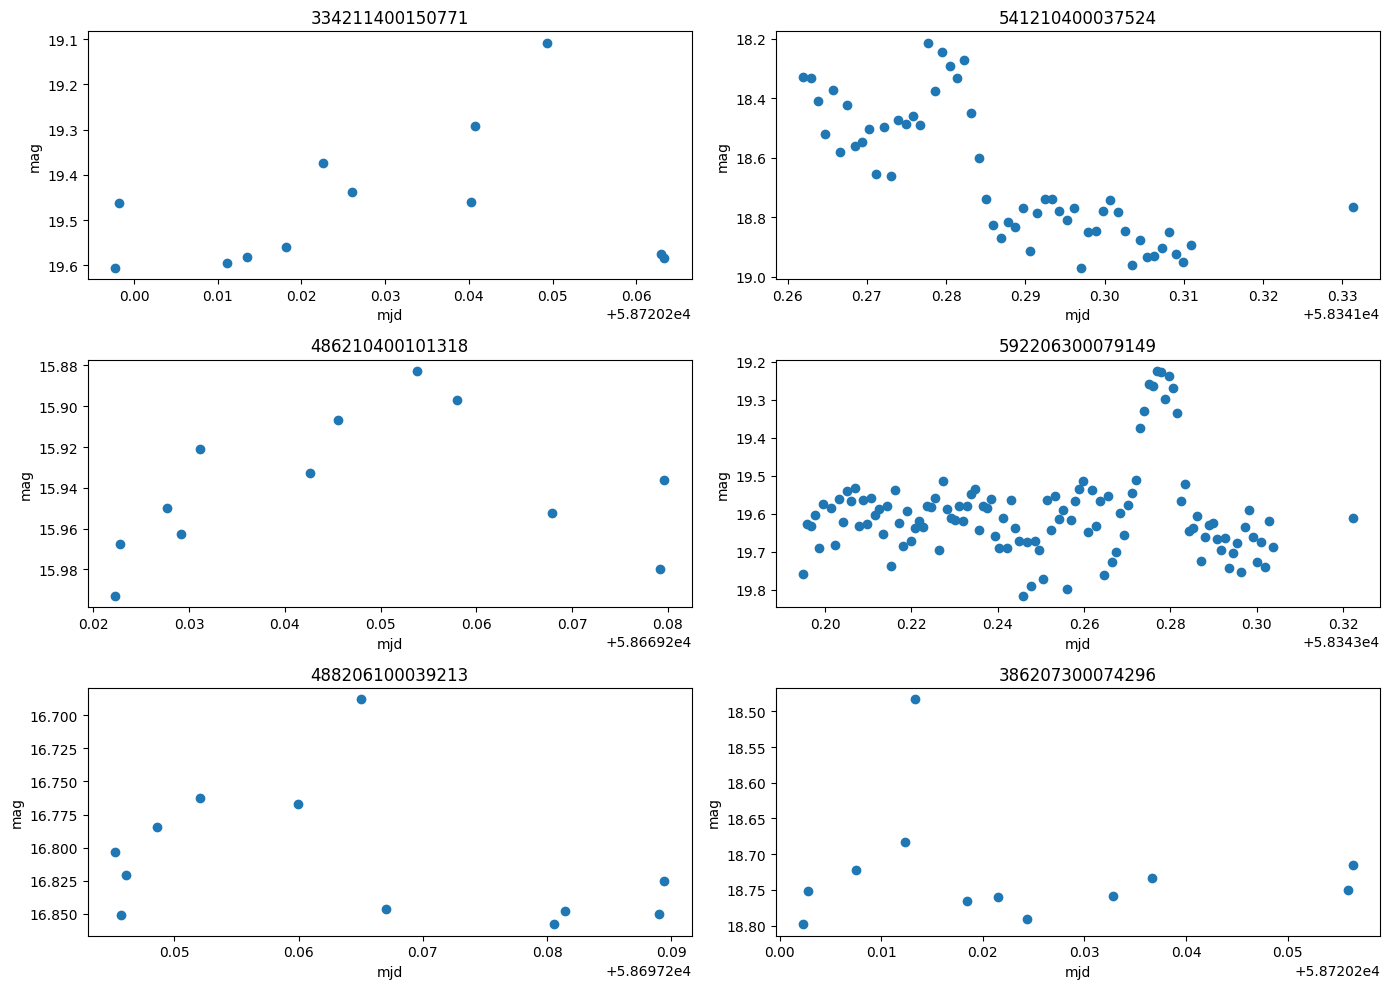

In [19]:
plot_false_predicted(clf, pos=True)